# Accuracy of color representation using Bayesian shape calculations 

> This notebook shows an example to evaluate the accurate representation of data sets by using several current available color maps.

- toc: true
- branch: master
- badges: true
- comments: false
- author: Andres Cifuentes-Lopez, Korak Ray, Anjali Verma, Ruben Gonzalez and Colin Kinz-Thompson
- categories: [colormaps, lightness, data] 

Color is a crucial element of images that plays a significant role in assigning meaning to information within the image, so, for that reason, [the accurate color representation of data, plays an important role in science communication](https://www.nature.com/articles/s41467-020-19160-7) (Crameri, F. et al., 2020).

Here we evaluate how well a colormap represents the underlying data by applying the Bayesian inference shape analysis framework in order to see if the colormap distorts the data.

In [1]:
import numpy as np
np.seterr(all='ignore')
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import matplotlib.colors as pltcol
from scipy.special import betainc,betaln,gammaln

In [2]:
# Change this section to change the colormaps
c_maps = [plt.cm.jet, plt.cm.viridis, plt.cm.cividis, plt.cm.inferno, plt.cm.plasma, plt.cm.magma, plt.cm.rainbow]
c_labels = ["Jet", "Viridis", "Cividis", "Inferno", "Plasma", "Magma", "Rainbow"]
colors = ["red", "green", "blue", "orange", "purple", "gray", "black"]
markers = ["o", "^", "s", "p", "*", "X", "D"]

In [3]:
lnprior_factor_location = 5.*np.log(10) +np.log(2.)## +10^5 to -10^5: 1/(\delta \mu)
lnprior_factor_scale = np.log(2 * 3*np.log(10.)) ## +/-3 decades: 1/(\delta ln(\tau))

def ln_evidence(x,y):
    ### 2.2.2
    
    N = float(x.size)
    M = N/2.-1.
    Ex = np.mean(x)
    Ey = np.mean(y)
    Exx = np.mean(x*x)
    Eyy = np.mean(y*y)
    Exy = np.mean(x*y)
    vx = Exx-Ex*Ex
    vy = Eyy-Ey*Ey
    vxy = Exy-Ex*Ey

    ## underflow protection
    if vx <= 0 or vy <= 0 or vxy == 0: ## vxy can be negative
        return -np.inf

    r = vxy/np.sqrt(vx*vy)
    r2 = r*r
    out = gammaln(M) -N/2.*np.log(N) -.5*np.log(vx) -np.log(2) -2.*lnprior_factor_location -lnprior_factor_scale -M*np.log(np.pi) -M*np.log(vy) -M*np.log(1.-r2) + np.log(1.+r/np.abs(r)*betainc(.5,M,r2))

    return out

# Obtaining a simulated dataset

Here we can see each colormap representation of simulating data (left) and its calculated lightness (right). For each calculation in the next section the lightness was used.

### Transforming data to lightness
To get the simulated lightness data for each color map we did the following:

- First let us simulate a 2D histogram picture, to replicate a more realistic data set, we use a random data generation followed by a median and gaussian filter.

- Once we obtained the histogram dataset, we transformed each pixel to a color space coordinates, in this case, we used RGBA color space.

- Carry out the shape analysis between colormaps requires computing a most general parameter common to all colormaps, here we choose the relative lightness by using the [luma](https://en.wikipedia.org/wiki/Luma_(video)) relative lightness expression. 
- This analysis was carried out for by using a set of perceptually uniform sequential color maps implemented in matplotlib (Cividis, Viridis, Plasma, Inferno, and, Magma) and two of the miscellaneous colormaps (Jet and, Rainbow).

In [4]:
#Normalized histogram Data
def his(n=10000, bins=30, seed=4):
    np.random.seed(seed)
    d = np.random.rand(n,2)
    d_x_g = ndi.gaussian_filter(ndi.median_filter(d[:,0], size=10), sigma = 1)
    d_y_g = ndi.gaussian_filter(ndi.median_filter(d[:,1], size=10), sigma = 1)
    H, x_bin, y_bin = np.histogram2d(d_x_g, d_y_g, bins=(bins,bins))
    f = (H-H.min())/(H.max()-H.min())
    f = f.reshape((bins,bins,1))
    return f

In [5]:
#Transformation to RGBA
def to_rgba(f,cmap):
    nx,ny,_ = f.shape
    out = np.zeros([nx,ny,4])
    for i in range(nx):
        for j in range(ny):
            out[i,j,:] = cmap(f[i,j,0])
    return out

def compute_lightness(f,cmap):
    c = to_rgba(f,cmap)
    lum = 0.212 * c[:,:,0] + 0.715 * c[:,:,1] + 0.072 * c[:,:,2]
    lum = lum[:,:,None]
    return lum

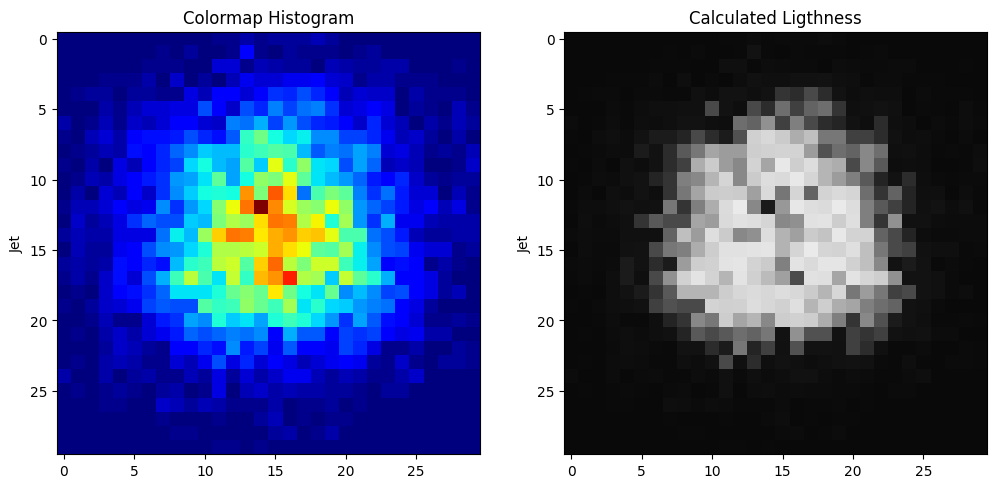

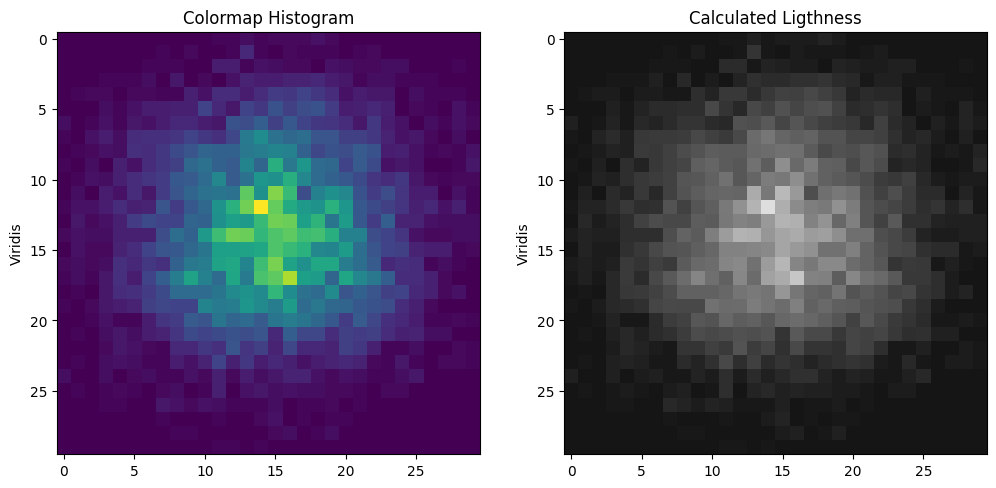

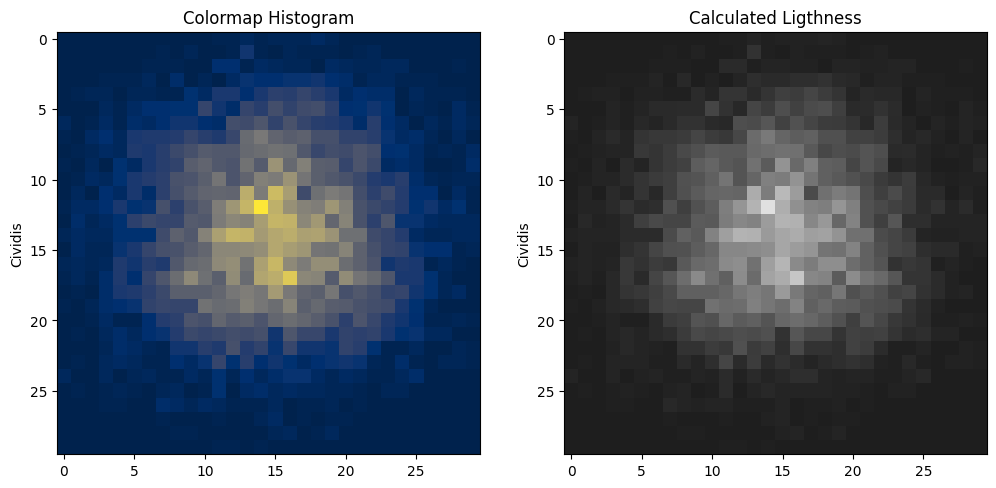

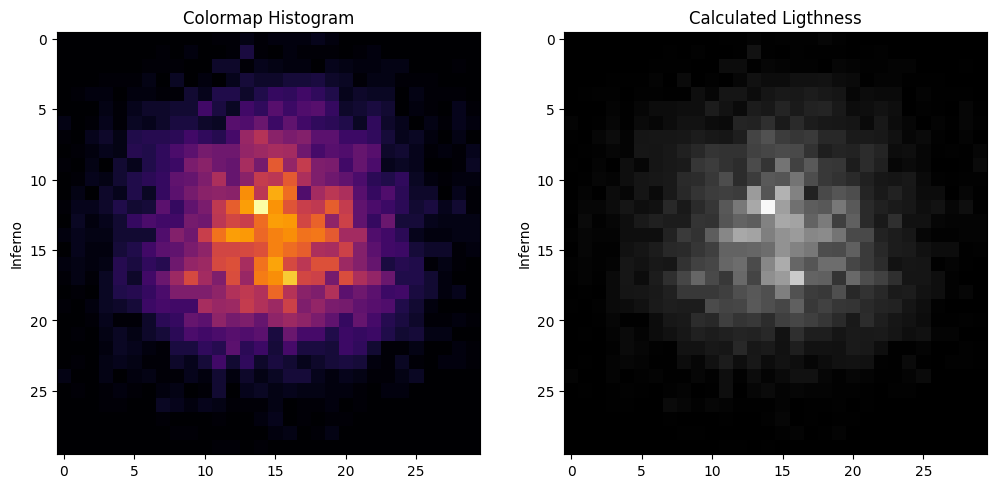

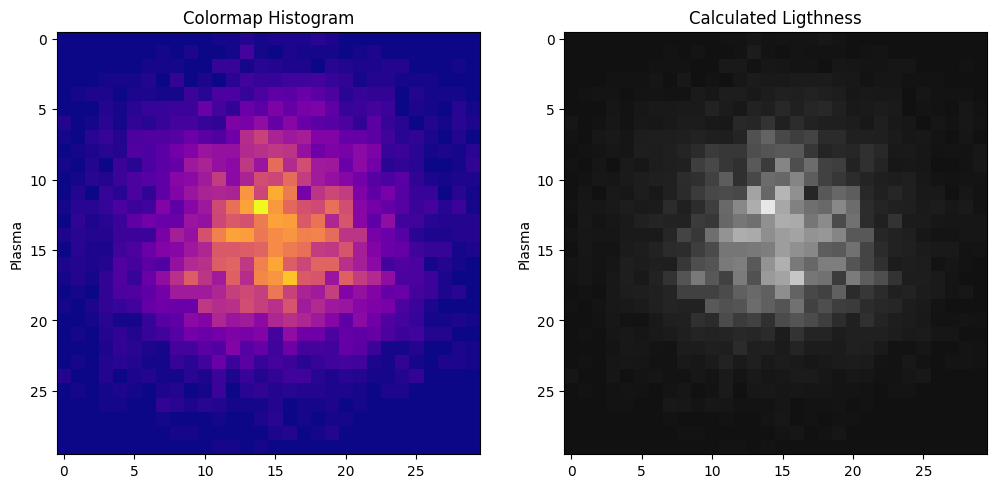

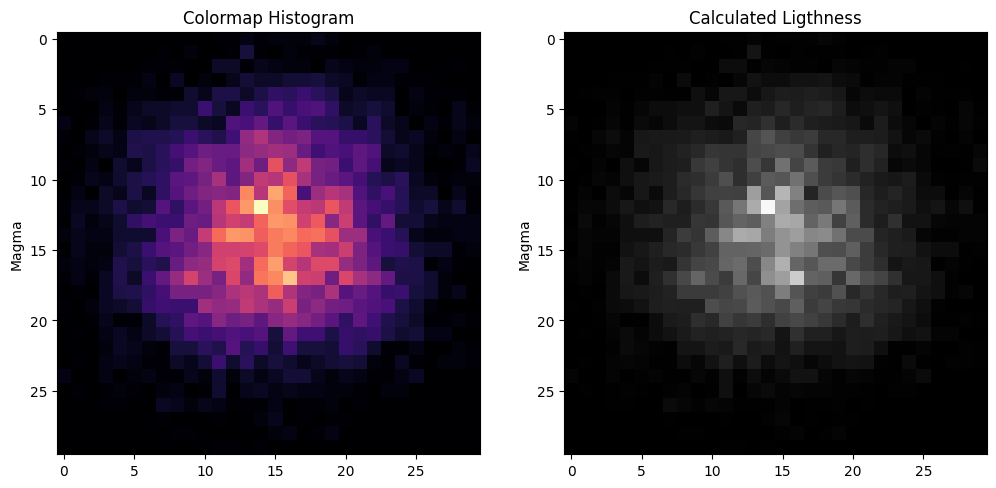

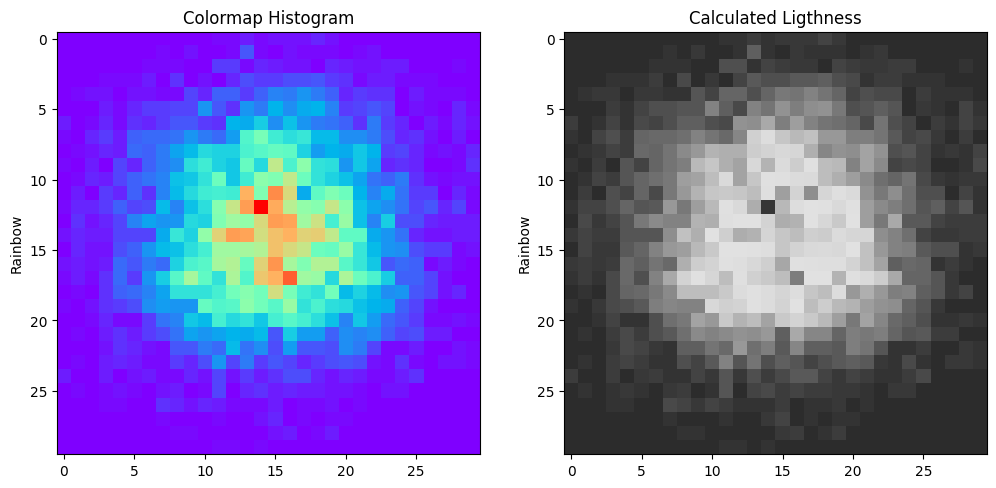

In [6]:
bins = 30
f = his(bins=bins)
lum_val = np.empty((len(c_maps), bins, bins,1))
for cmap_idx, cmap in enumerate (c_maps):
    L = compute_lightness(f,cmap)
    lum_val[cmap_idx] = L
    
cmap_L = plt.cm.gray
for cmap, L, label in zip(c_maps, lum_val, c_labels):
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(f, cmap=cmap,interpolation='nearest')
    ax[0].set_title('Colormap Histogram')
    ax[0].set_ylabel(label)
    ax[1].imshow(L,cmap=cmap_L, interpolation='nearest', vmin=0, vmax=1)
    ax[1].set_title('Calculated Ligthness')
    ax[1].set_ylabel(label)
    plt.show()

# Computing the best colormap

Here we compare the different colormaps to find which one best respresents the data.
For each colormap, we used the shape analysis theory to compute the evidence that the original data is described by a template made from the lightness of that colormap (left).
Then we used Bayesian model selection (BMS) to compute which is the best of these colormaps at representing the data (right). 

In [7]:
Evidence_val = []
for i in range(lum_val.shape[0]):
    x = lum_val[i]
    ev = ln_evidence(x,f)
    Evidence_val.append(ev)
lev = np.array(Evidence_val)
levd = lev - np.max(lev)
prob = []
for i in range(levd.size):
    p = 1./np.sum(np.exp(levd-levd[i]))
    prob.append(p)
prob = np.array(prob)

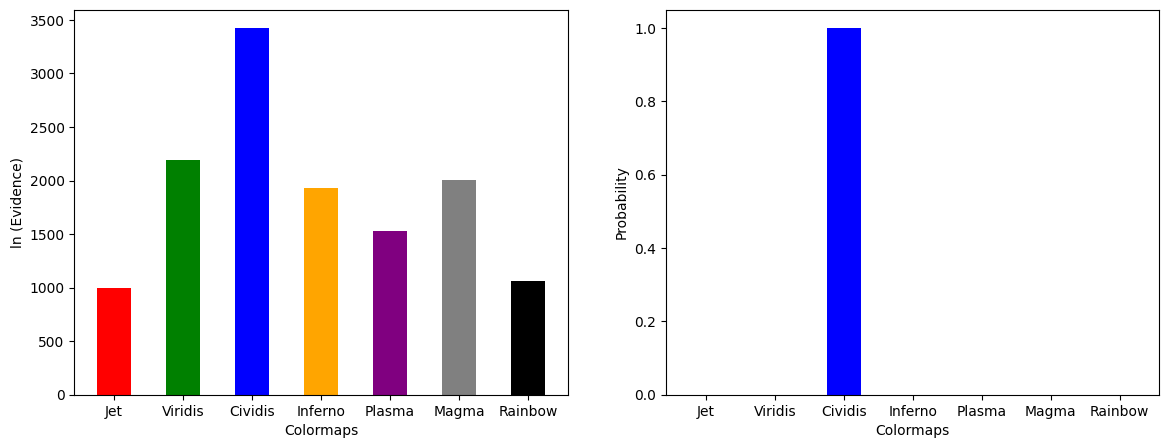

In [8]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
bar_width = 0.5
x_pro = np.arange(prob.size)
x_evi = np.arange(lev.size)

ax[0].bar(x_evi, lev, width=bar_width, color=colors)
ax[0].set_xlabel('Colormaps')
ax[0].set_ylabel('ln (Evidence)')
ax[0].set_xticks(x_evi)
ax[0].set_xticklabels(c_labels)
ax[1].bar(x_pro, prob, width=bar_width, color=colors)
ax[1].set_xlabel('Colormaps')
ax[1].set_ylabel('Probability')
ax[1].set_xticks(x_pro)
ax[1].set_xticklabels(c_labels)
plt.show()

Here we show the calculated natural logarithm of evidence (left picture) where the higher values were obtained for the perceptually uniform sequential colormaps (i.e., cividis, viridis, inferno, plasma, magma).  Although this group shares the same development principle, we obtained significantly different evidence values for all of them, where “Cividis” significantly better represents the data. Related to the other colormaps tested, “Jet” colormap is the one with the lowest evidence value, which means this one is the colormap with the least accurate reproduction of the simulated dataset.

# Why is cividis better ??

In the figure below we show the lightness linearity of each colormap. The linearity directly correlates to the evidence values. This is because our Bayesian inference calculation directly compared the linearity of lightness to the data. In the plot below you can see Cividis is the colormap which has the most perceptually linear lightness, which is why it was the best of the colormaps we investigated.

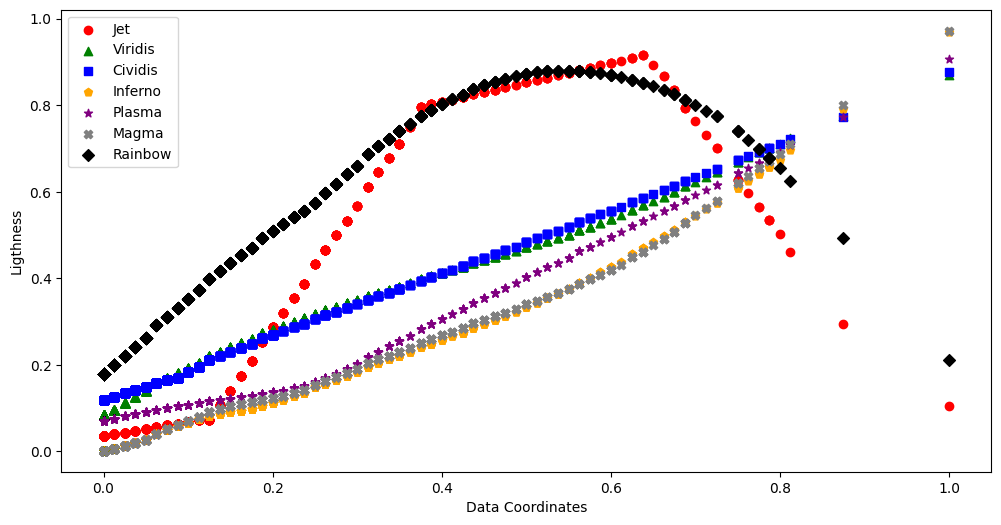

In [9]:
f_flat = f.reshape(900,1)
n, h, w, c = lum_val.shape  
lum_flat = lum_val.reshape(n, h*w*c)

fig, ax = plt.subplots(figsize=(12,6))
for i in range(n):
    ax.scatter(f_flat, lum_flat[i], color=colors[i%len(colors)], label=c_labels[i%len(c_labels)], marker = markers[i%len(markers)])
ax.legend()
ax.set_xlabel('Data Coordinates')
ax.set_ylabel('Ligthness')
plt.show()